In [1]:
import pandas as pd
import os
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import nfl_data_py as nfl
from explore import summarize_df, check_missing_values
from transform import filter_to_plays, remove_weeks, aggregate_df, add_calc_stats
from model import rf_model_evaluate, logreg_model_evaluate
from predict import predict_winner, predict_week
from optimize import optimize_year

In [2]:
# find best range of years to train on
#optimize_year((2021, 2023), 2024, 'logreg')

In [3]:
# range of years to pull from
years = list(range(2021,2024))

# columns to pull from database
columns =   ['play_id', 'game_id', 'home_team', 'away_team', 'season_type', 'week', 'posteam', 'posteam_type',
             'side_of_field', 'yardline_100', 'game_date', 'game_seconds_remaining', 'down', 'ydsnet', 'desc',
             'play_type', 'yards_gained', 'pass_length', 'yards_after_catch', 'field_goal_result', 
             'kick_distance', 'extra_point_result', 'two_point_conv_result', 'total_home_score', 
             'total_away_score', 'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa', 
             'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa', 'wp', 'def_wp', 'home_wp', 
             'away_wp', 'wpa', 'total_home_rush_wpa', 'total_away_rush_wpa', 'total_home_pass_wpa', 
             'total_away_pass_wpa', 'punt_blocked', 'first_down_rush', 'first_down_pass', 
             'first_down_penalty', 'third_down_converted', 'third_down_failed', 'fourth_down_converted', 
             'fourth_down_failed', 'incomplete_pass', 'touchback', 'interception', 'fumble_forced', 
             'fumble_not_forced', 'fumble_out_of_bounds', 'safety', 'penalty', 'fumble_lost', 'rush_attempt', 
             'pass_attempt', 'sack', 'touchdown', 'pass_touchdown', 'rush_touchdown', 'return_touchdown', 
             'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt', 'kickoff_attempt', 
             'punt_attempt', 'fumble', 'complete_pass', 'passing_yards', 'receiving_yards', 'rushing_yards', 
             'return_yards', 'penalty_team', 'penalty_yards', 'penalty_type', 'season', 'series_result', 
             'weather', 'play_type_nfl', 'special_teams_play', 'drive_first_downs', 
             'drive_inside20', 'drive_ended_with_score', 'away_score', 'home_score', 'location', 
             'result', 'total', 'spread_line', 'total_line', 'surface', 'temp', 'wind', 'pass', 
             'rush', 'first_down', 'special', 'play', 'qb_epa']

# create df with combined data
df = nfl.import_pbp_data(years, downcast=True)

2021 done.
2022 done.
2023 done.
Downcasting floats.


In [4]:
# display first n rows, number of rows, number of columns, number of duplicates
summarize_df(df, display_rows=10)


First 10 rows:
   play_id          game_id old_game_id_x home_team away_team season_type  \
0      1.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
1     40.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
2     55.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
3     76.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
4    100.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
5    122.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
6    152.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
7    181.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
8    218.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   
9    253.0  2021_01_ARI_TEN    2021091207       TEN       ARI         REG   

   week posteam posteam_type defteam  ...  \
0     1    None         None    None  ...   
1     1     TEN         home     ARI  ...   
2

In [ ]:
# display how many nans are in each column (check_missing_values returns df of missing values)
check_missing_values(df, display_rows=391)

                            Column  NA_Count
0                    end_yard_line    149021
1           lateral_sack_player_id    149021
2         lateral_sack_player_name    149021
3    tackle_for_loss_2_player_name    149021
4      tackle_for_loss_2_player_id    149021
..                             ...       ...
386                  no_score_prob         0
387                    opp_fg_prob         0
388                opp_safety_prob         0
389                    opp_td_prob         0
390                        play_id         0

[391 rows x 2 columns]


,Column,NA_Count
0,end_yard_line,149021
1,lateral_sack_player_id,149021
2,lateral_sack_player_name,149021
3,tackle_for_loss_2_player_name,149021
4,tackle_for_loss_2_player_id,149021
...,...,...
386,no_score_prob,0
387,opp_fg_prob,0
388,opp_safety_prob,0
389,opp_td_prob,0


In [6]:
# filter df to only include plays (gets rid of timeouts, penalties, start of game, etc.)
filtered_df = filter_to_plays(df)

# use one hot encoding on the listed columns
columns_to_encode = ['field_goal_result',
                     'extra_point_result',
                     'two_point_conv_result']
encoded_df = pd.get_dummies(filtered_df, columns=columns_to_encode, drop_first=True)
encoded_df['penalty_yards'] = encoded_df['penalty_yards'].where(encoded_df['penalty_team'] == encoded_df['posteam'], -encoded_df['penalty_yards'])

# columns to group by in aggregate_df
group_by = ['game_id', 'posteam', 'home_team', 'away_team']

# dict of columns to be included in aggregated_df and the corresponding functions to be applied
column_functions = {'yards_gained': 'sum',
                    'receiving_yards': 'sum',
                    'rushing_yards': 'sum',
                    'return_yards': 'sum',
                    'incomplete_pass': 'sum',
                    'complete_pass': 'sum',
                    'interception': 'sum',
                    'pass_attempt': 'sum',
                    'rush_attempt': 'sum',
                    'touchdown': 'sum',
                    'pass_touchdown': 'sum',
                    'rush_touchdown': 'sum',
                    'return_touchdown': 'sum',
                    'first_down': 'sum',
                    'play': 'sum',
                    'sack': 'sum',
                    'fumble': 'sum',
                    'fumble_lost': 'sum',
                    'field_goal_result_made': 'sum',
                    'field_goal_result_missed': 'sum',
                    'extra_point_result_good': 'sum',
                    'extra_point_result_failed': 'sum',
                    'safety': 'sum',
                    'total_home_epa': 'max',
                    'total_away_epa': 'max',
                    'total_home_score': 'max',
                    'total_away_score': 'max',
                    'total': 'max',
                    'penalty_yards': 'sum'
                    }

# turn column_functions into a df
df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

# create aggregated_df
aggregated_df = aggregate_df(encoded_df, group_by, df_column_functions)

# add calculated stats columns (win, season, yards_per_play_offense, points_per_play_offense, 
#                               first_down_rate_offense, turnovers_lost, yards_per_play_allowed, 
#                               points_per_play_allowed, first_down_rate_allowed, turnovers_gained,
#                               turnover_differential, fg percentage, xp percentage)
transformed_df = add_calc_stats(aggregated_df, encoded_df)

c:\Users\alrec\Desktop\DAT Capstone\DAT-Capstone\transform.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [14]:
# select features to be used in models
features = ['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
            'first_down_rate_allowed', 'turnover_differential']
# select target_variable
target_variable = 'win'

# create X (df of feature columns) and y (series for the target variable)
X = transformed_df[features]
y = transformed_df[target_variable]
    
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Accuracy: 0.8099
Confusion Matrix:
[[125  40]
 [ 25 152]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.76      0.79       165
           1       0.79      0.86      0.82       177

    accuracy                           0.81       342
   macro avg       0.81      0.81      0.81       342
weighted avg       0.81      0.81      0.81       342



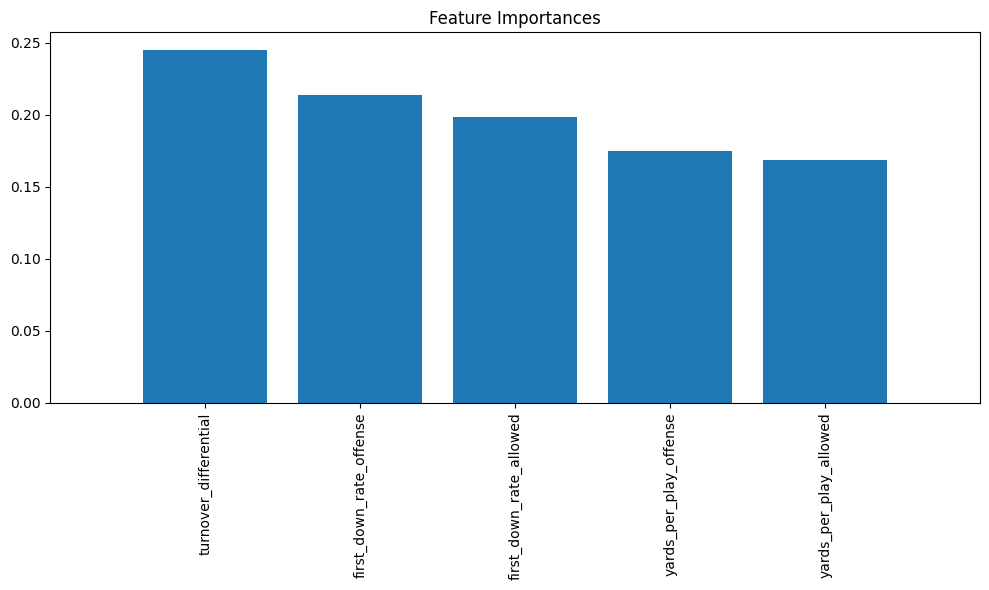

In [15]:
# create and evaluate random forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_model_evaluate(rf_model, features_test=X_test, target_test=y_test, tree_plot=False, feature_importance=True)

Accuracy: 0.8216
Confusion Matrix:
[[128  37]
 [ 24 153]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       165
           1       0.81      0.86      0.83       177

    accuracy                           0.82       342
   macro avg       0.82      0.82      0.82       342
weighted avg       0.82      0.82      0.82       342


Feature Importance:
                   Feature  Coefficient  Importance
1  first_down_rate_offense     4.016363    4.016363
3  first_down_rate_allowed    -3.650892    3.650892
0   yards_per_play_offense     0.903644    0.903644
4    turnover_differential     0.885962    0.885962
2   yards_per_play_allowed    -0.860012    0.860012


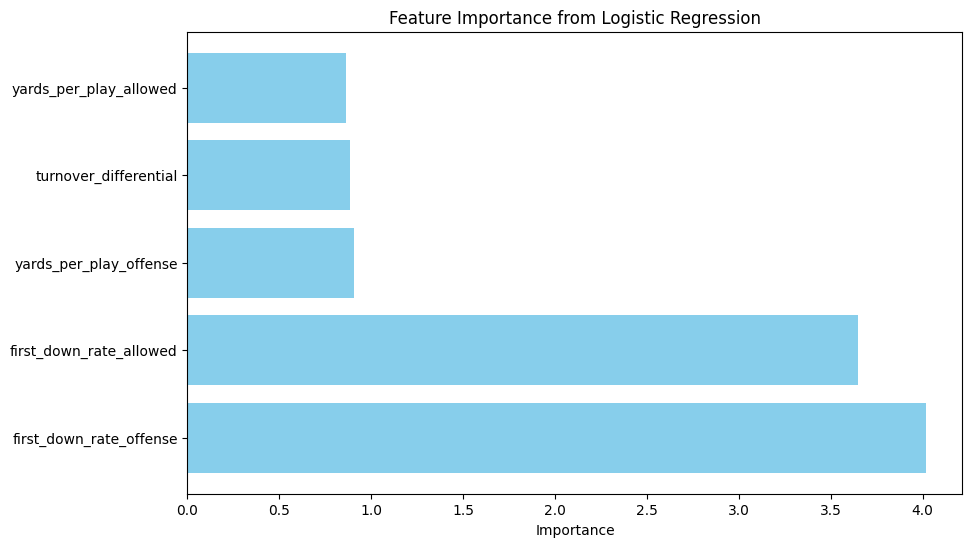

      Actual  Predicted  Probability
567        0          0     0.483679
1325       1          1     0.768074
1350       0          0     0.398612
115        0          0     0.079073
453        0          1     0.762651
1368       1          1     0.676960
483        1          0     0.194575
614        0          0     0.029774
1185       0          0     0.062028
915        1          1     0.800286


In [16]:
# create and evaluate logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
print(logreg_model_evaluate(logreg_model, X_test, y_test, feature_importance=True).head(10))

In [17]:
# load the current season's play by play data
df_current = nfl.import_pbp_data([2024], columns, downcast=True)

# create filtered_df_current
filtered_df_current = filter_to_plays(df_current)

# remove selected weeks
weeks_to_remove = []
filtered_df_current = remove_weeks(filtered_df_current, weeks_to_remove)

# create encoded_df_current
encoded_df_current = pd.get_dummies(filtered_df_current, columns=columns_to_encode, drop_first=True)
encoded_df_current['penalty_yards'] = encoded_df_current['penalty_yards'].where(encoded_df_current['penalty_team'] == encoded_df_current['posteam'], -encoded_df_current['penalty_yards'])

# create aggregated_df_current
aggregated_df_current = aggregate_df(encoded_df_current, group_by, df_column_functions)

# create transformed_df_current
transformed_df_current = add_calc_stats(aggregated_df_current, encoded_df_current)

2024 done.
Downcasting floats.
Unique weeks in the DataFrame: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
Weeks removed: []


ValueError: DataFrame is missing one or more required columns

In [ ]:
# column functions parameter for aggregate_df the second time
column_functions = {'turnover_differential': 'mean',
                    'first_down_rate_allowed': 'mean',
                    'first_down_rate_offense': 'mean',
                    'yards_per_play_allowed': 'mean',
                    'yards_per_play_offense': 'mean'}
df_column_functions = pd.DataFrame(list(column_functions.items()), columns=['Column', 'Function'])

# aggregate season_team_df
season_team_df_2024 = aggregate_df(transformed_df_current, ['posteam'], df_column_functions)

c:\Users\alrec\Desktop\DAT Capstone\DAT-Capstone\transform.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  aggregated = df.groupby(group_by_list).agg(column_func_df.set_index('Column')['Function']).reset_index()


In [ ]:
# identify features from season_team_df_current
features = season_team_df_2024[['yards_per_play_offense', 'first_down_rate_offense', 'yards_per_play_allowed', 
                                'first_down_rate_allowed', 'turnover_differential']]

# scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# create scaled_df_current
scaled_df_2024 = pd.DataFrame(scaled_features, columns=features.columns)
scaled_df_2024['posteam'] = season_team_df_2024['posteam']
scaled_df_2024 = scaled_df_2024.reset_index(drop=True)

In [ ]:
# predict the winner of an nfl game
home = 'BAL'
away = 'CAR'
predicted_winner, winning_probability, home_prob, away_prob = predict_winner(logreg_model, scaled_df_2024, home, away)
print(f"Predicted Winner: {predicted_winner}, Probability: {winning_probability:.2f}%, home: {home_prob}, away: {away_prob}")

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- interception
- penalty_yards
- sack


In [ ]:
# predict a week of nfl games
week_schedule = [
    ('DEN', 'BUF'),
    ('LAC', 'HOU'),
    ('PIT', 'BAL'),
    ('GB', 'PHI'),
    ('WAS', 'TB'),
    ('MIN', 'LA')
]

predictions_df = predict_week(logreg_model, scaled_df_2024, week_schedule)
print(predictions_df)

   Home Away Predicted Winner  Winning Probability (%)  \
0   DAL  HOU              HOU                     5.00   
1    NE   LA               LA                     5.00   
2   DET  JAX              DET                     4.93   
3    NO  CLE               NO                     4.99   
4   MIA   LV              MIA                     4.24   
5   TEN  MIN              MIN                     1.64   
6   NYJ  IND              NYJ                     4.29   
7   LAC  CIN              LAC                     1.82   
8    SF  SEA               SF                     2.02   
9   DEN  ATL              DEN                     0.93   
10  CHI   GB              CHI                     0.88   
11  PHI  WAS              PHI                     0.19   
12  PIT  WAS              PIT                     0.18   
13  BUF   KC               KC                     0.03   

    Home Win Probability (%)  Away Win Probability (%)  
0                       0.00                      0.92  
1              

In [ ]:
# download any models or datasets
i = input("Would you like to save any files from the project? (y/n)")
if i in {'Y','y', 'ex'}:
    i = input("Would you like to save the models to a folder? (y/n)")
    if i in {'Y','y', 'ex'}:
        if i == 'ex':
            filepath = r'C:/Users/alrec/Desktop/DAT Capstone/models'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ")
        os.makedirs(filepath, exist_ok=True)
        #joblib.dump(linreg_model, f'{filepath}\linreg_model.pkl')
        #joblib.dump(ridge_model, f'{filepath}/ridge_model.pkl')
        #joblib.dump(lasso_model, f'{filepath}\lasso_model.pkl')
        joblib.dump(rf_model, f'{filepath}/rf_model.pkl')
        joblib.dump(logreg_model, f'{filepath}/logreg_model.pkl')
        print('models saved')
    
    i = input("Would you like to save the data to a folder? (y/n)").strip()

    if i in {'Y', 'y', 'ex'}:
        if i == 'ex':
            filepath = r'C:/Users/alrec/Desktop/DAT Capstone/dataframes'
        else:
            filepath = input("Please enter the filepath for the folder to save to: ").strip()
        
        os.makedirs(filepath, exist_ok=True)
        
        df.to_csv(os.path.join(filepath, 'df.csv'), index=False)
        filtered_df.to_csv(os.path.join(filepath, 'filtered_df.csv'), index=False)
        encoded_df.to_csv(os.path.join(filepath, 'encoded_df.csv'), index=False)
        aggregated_df.to_csv(os.path.join(filepath, 'aggregated_df.csv'), index=False)
        transformed_df.to_csv(os.path.join(filepath, 'transformed_df.csv'), index=False)

        df_current.to_csv(os.path.join(filepath, 'df_current.csv'), index=False)
        filtered_df_current.to_csv(os.path.join(filepath, 'filtered_df_current.csv'), index=False)
        encoded_df_current.to_csv(os.path.join(filepath, 'encoded_df_current.csv'), index=False)
        aggregated_df_current.to_csv(os.path.join(filepath, 'aggregated_df_current.csv'), index=False)
        transformed_df_current.to_csv(os.path.join(filepath, 'transformed_df_current.csv'), index=False)

        season_team_df_2024.to_csv(os.path.join(filepath, 'season_team_df_2024.csv'), index=False)
        scaled_df_2024.to_csv(os.path.join(filepath, 'scaled_df_2024.csv'), index=False)

        predictions_df.to_csv(os.path.join(filepath, 'results_df_2024.csv'), index=False)

        print('Dataframes saved successfully')


models saved
Dataframes saved successfully
